In [62]:
# === Rutas y utilitarios (consistentes con src/) ===
from pathlib import Path
import os, random
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import torch

# Usa los mismos splits que en src: cambia a True si entrenaste con --small
USE_SMALL = False  # True -> train_small/val_small/test_small ; False -> train/val/test

ROOT        = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR    = ROOT / "data"

ART_BASE    = ROOT / "artifacts" / "baseline_es"
ART_BERT    = ROOT / "artifacts" / "bert_es"
ART_ROBERTA = ROOT / "artifacts" / "roberta_es"
REPO        = ROOT / "reports"
for p in [ART_BASE, ART_BERT, ART_ROBERTA, REPO]:
    p.mkdir(parents=True, exist_ok=True)

# Estilo y semillas
plt.rcParams['figure.figsize'] = (7, 4)
pd.set_option('display.max_colwidth', 140)
SEED = 42
np.random.seed(SEED); random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)
if torch.cuda.is_available():
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

print("ROOT:", ROOT)
print("Modo:", "SMALL" if USE_SMALL else "FULL")

# Paths activos (coinciden con src)
suf = "_small" if USE_SMALL else ""
TRAIN_CSV = DATA_DIR / f"train{suf}.csv"
VAL_CSV   = DATA_DIR / f"val{suf}.csv"
TEST_CSV  = DATA_DIR / f"test{suf}.csv"
print("Train existe?:", TRAIN_CSV.exists(), "| Val?:", VAL_CSV.exists(), "| Test?:", TEST_CSV.exists())

# (Opcional) INFO CUDA del kernel del notebook
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


ROOT: c:\Users\VICTUS\Downloads\TESIS codigo
Modo: FULL
Train existe?: True | Val?: True | Test?: True
CUDA disponible: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [64]:
# === Carga y preprocesamiento (SIN rehacer splits) ===
import re, unicodedata
from pathlib import Path

# 0) Configuración y autodetección SMALL/FULL
USE_SMALL = globals().get("USE_SMALL", None)
if USE_SMALL is None:
    USE_SMALL = (DATA_DIR / "train_small.csv").exists() and \
                (DATA_DIR / "val_small.csv").exists() and \
                (DATA_DIR / "test_small.csv").exists()
print("Modo:", "SMALL" if USE_SMALL else "FULL")

# Si quieres forzar recalcular "text_clean" aunque ya exista, pon True
OVERWRITE_CLEAN = False

# 1) Normalización mejorada (URLs, @, #palabra, minúsculas, emojis→texto opcional, limpieza suave)
try:
    import emoji
    _HAS_EMOJI = True
except Exception:
    _HAS_EMOJI = False

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # a) normaliza y minúsculas
    s = unicodedata.normalize("NFC", s).lower().strip()
    # b) elimina URLs y menciones; hashtag -> palabra
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#(\w+)", r"\1", s)
    # c) emojis → texto (si hay librería)
    if _HAS_EMOJI:
        s = emoji.demojize(s, language="es")
        s = s.replace(":", " ")   # :smiling_face: ->  smiling_face
    # d) limpia símbolos manteniendo letras con tildes/ñ y dígitos
    s = re.sub(r"[^\w\sáéíóúüñ]", " ", s, flags=re.IGNORECASE)
    # e) espacios extra
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 2) Archivos a usar EXACTAMENTE como en src/ (depende de USE_SMALL)
suffix   = "_small" if USE_SMALL else ""
train_csv = DATA_DIR / f"train{suffix}.csv"
val_csv   = DATA_DIR / f"val{suffix}.csv"
test_csv  = DATA_DIR / f"test{suffix}.csv"

# 3) Verifica que existan
for p in [train_csv, val_csv, test_csv]:
    if not p.exists():
        raise FileNotFoundError(
            f"No encuentro {p}. Genera los splits con data/download.py "
            f"(usa --small si corresponde)."
        )

# 4) Carga tal cual (sin re-split) y crea/actualiza columnas *_clean según flag
def load_and_clean(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # homogeneiza nombres
    if "text" not in df.columns:
        for c in ["text_clean","body","content","tweet","sentence","message"]:
            if c in df.columns:
                df = df.rename(columns={c:"text"})
                break
    assert {"text","label"}.issubset(df.columns), f"Faltan columnas text/label en {path.name}"

    if OVERWRITE_CLEAN or "text_clean" not in df.columns:
        df["text_clean"] = df["text"].astype(str).apply(normalize_text)
    else:
        # garantiza que text_clean sea str (por si vino de disco)
        df["text_clean"] = df["text_clean"].astype(str)

    return df[["text","text_clean","label"]].dropna()

train_df = load_and_clean(train_csv)
val_df   = load_and_clean(val_csv)
test_df  = load_and_clean(test_csv)

# 5) (Opcional) guarda las versiones clean para usarlas siempre igual
train_df[["text_clean","label"]].to_csv(DATA_DIR / f"train{suffix}_clean.csv", index=False)
val_df[  ["text_clean","label"]].to_csv(DATA_DIR / f"val{suffix}_clean.csv",   index=False)
test_df[ ["text_clean","label"]].to_csv(DATA_DIR / f"test{suffix}_clean.csv",  index=False)

print("✅ Cargados (sin re-split):")
print("Train:", train_df.shape, "| Val:", val_df.shape, "| Test:", test_df.shape)
print("Emoji -> texto:", "ON" if _HAS_EMOJI else "OFF (instala `emoji` si lo quieres)")


Modo: FULL
✅ Cargados (sin re-split):
Train: (20758, 3) | Val: (4450, 3) | Test: (4449, 3)
Emoji -> texto: OFF (instala `emoji` si lo quieres)


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_38356\1729769779.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=train_df, palette=["#4472C4", "#ED7D31"])


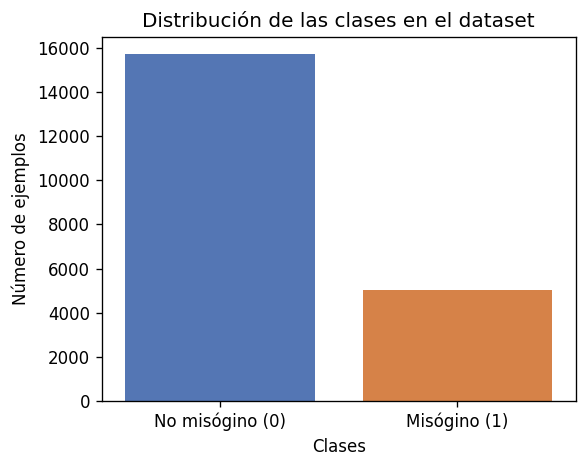

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que tu DataFrame se llama df o train_df
plt.figure(figsize=(5,4), dpi=120)
sns.countplot(x="label", data=train_df, palette=["#4472C4", "#ED7D31"])
plt.xticks([0,1], ["No misógino (0)", "Misógino (1)"])
plt.title("Distribución de las clases en el dataset")
plt.xlabel("Clases")
plt.ylabel("Número de ejemplos")
plt.tight_layout()
plt.savefig(REPO / "figura_5_1_distribucion_clases.png", dpi=160)
plt.show()


📦 Cargando baseline (firma ccc94ea0)…
              precision    recall  f1-score   support

No Misoginia       0.90      0.85      0.88      3366
   Misoginia       0.61      0.72      0.66      1083

    accuracy                           0.82      4449
   macro avg       0.76      0.78      0.77      4449
weighted avg       0.83      0.82      0.82      4449



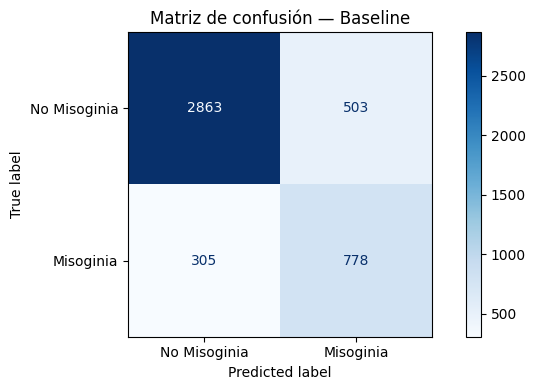

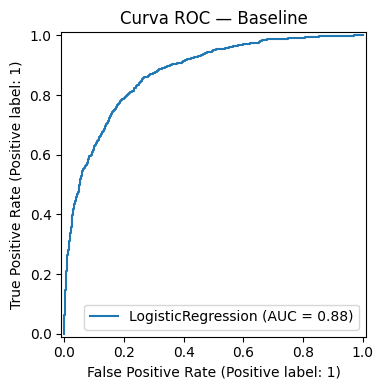

In [ ]:
import sys, os
sys.path.append(os.path.abspath("src"))

from baseline import BaselineConfig, run_baseline

cfg = BaselineConfig(
    data="data",
    art="artifacts/baseline_es",
    reports="reports",
    small=False,
    text_col="text_clean",   # o "text"
    min_df=3, max_df=0.9, ngrams=(1,2), C=1.0, seed=42
)
salidas = run_baseline(cfg)
salidas


📦 Cargando modelo BETO desde: C:\Users\VICTUS\Downloads\TESIS codigo\artifacts\bert_es


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


              precision    recall  f1-score   support

No Misoginia       0.90      0.91      0.91      3366
   Misoginia       0.72      0.70      0.71      1083

    accuracy                           0.86      4449
   macro avg       0.81      0.81      0.81      4449
weighted avg       0.86      0.86      0.86      4449



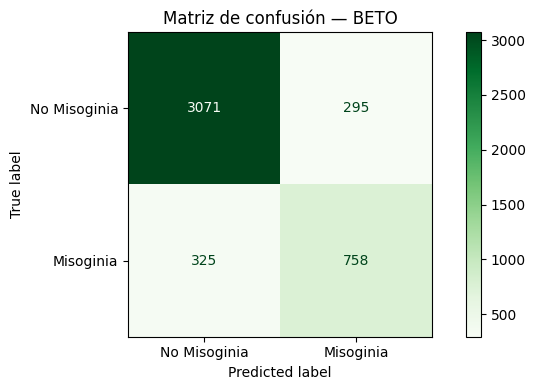

In [11]:
# Modelo BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch
import json
from math import ceil

rep_bert_dict = None

try:
    if not ART_BERT.exists():
        print("⚠️ No se encontró carpeta:", ART_BERT)
    else:
        print("📦 Cargando modelo BETO desde:", ART_BERT)
        tok = AutoTokenizer.from_pretrained(ART_BERT)
        model = AutoModelForSequenceClassification.from_pretrained(ART_BERT)
        device_id = 0 if torch.cuda.is_available() else -1
        pipe = TextClassificationPipeline(model=model, tokenizer=tok, device=device_id, truncation=True)

        # --- predicción en lotes (más estable en CPU/GPU)
        texts = test_df["text_clean"].tolist()
        batch_size = 64
        preds_idx = []
        for i in range(0, len(texts), batch_size):
            outs = pipe(texts[i:i+batch_size])
            # convertir LABEL_0/LABEL_1 → 0/1 (fallback al argmax si hace falta)
            for p in outs:
                if isinstance(p, dict) and "label" in p:
                    try:
                        idx = int(str(p["label"]).split("_")[-1])
                    except Exception:
                        idx = int(p.get("score", 0) < 0)  # fallback inocuo; casi nunca se usa
                else:
                    # muy raro, pero por si la lib cambia
                    idx = 1 if p.get("score", 0) > 0.5 else 0
                preds_idx.append(idx)

        y_pred_bert = np.array(preds_idx, dtype=int)

        # --- reporte + confusión
        rep_bert_dict = classification_report(
            test_df["label"], y_pred_bert,
            target_names=["No Misoginia","Misoginia"],
            output_dict=True, zero_division=0
        )
        rep_bert_txt = classification_report(
            test_df["label"], y_pred_bert,
            target_names=["No Misoginia","Misoginia"],
            digits=2, zero_division=0
        )
        print(rep_bert_txt)

        ConfusionMatrixDisplay.from_predictions(
            test_df["label"], y_pred_bert,
            display_labels=["No Misoginia","Misoginia"],
            cmap="Greens"
        )
        plt.title("Matriz de confusión — BETO")
        plt.tight_layout()
        plt.savefig(REPO / "confusion_beto.png", dpi=160)
        plt.show()

        # guardar métricas
        (REPO / "beto_metrics.json").write_text(json.dumps(rep_bert_dict, indent=2), encoding="utf-8")
        (REPO / "beto_metrics.txt").write_text(rep_bert_txt, encoding="utf-8")

except Exception as e:
    print("⚠️ No se pudo evaluar BETO:", e)

📦 Cargando modelo RoBERTa desde: C:\Users\VICTUS\Downloads\TESIS codigo\artifacts\roberta_es
              precision    recall  f1-score   support

No Misoginia       0.90      0.90      0.90      3366
   Misoginia       0.69      0.69      0.69      1083

    accuracy                           0.85      4449
   macro avg       0.80      0.80      0.80      4449
weighted avg       0.85      0.85      0.85      4449



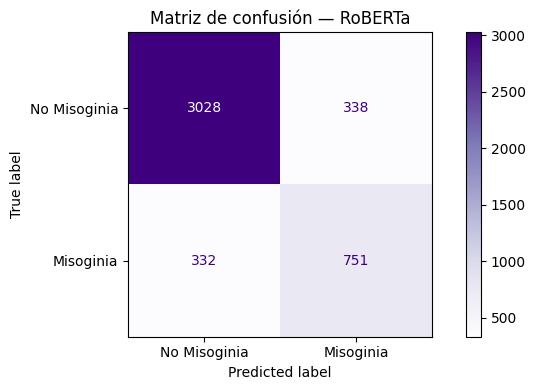

In [12]:
# === Modelo RoBERTa: evaluación batched y robusta ===
import json, numpy as np, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

rep_roberta_dict = None

try:
    if not ART_ROBERTA.exists():
        print("⚠️ No se encontró carpeta:", ART_ROBERTA)
    else:
        print("📦 Cargando modelo RoBERTa desde:", ART_ROBERTA)
        tok = AutoTokenizer.from_pretrained(ART_ROBERTA)
        model = AutoModelForSequenceClassification.from_pretrained(ART_ROBERTA)
        device_id = 0 if torch.cuda.is_available() else -1
        pipe = TextClassificationPipeline(model=model, tokenizer=tok, device=device_id, truncation=True)

        texts = test_df["text_clean"].tolist()
        batch_size = 64
        preds_idx = []
        for i in range(0, len(texts), batch_size):
            outs = pipe(texts[i:i+batch_size])
            for p in outs:
                if isinstance(p, dict) and "label" in p:
                    try:
                        idx = int(str(p["label"]).split("_")[-1])
                    except Exception:
                        idx = int(p.get("score", 0) < 0)
                else:
                    idx = 1 if p.get("score", 0) > 0.5 else 0
                preds_idx.append(idx)

        y_pred_roberta = np.array(preds_idx, dtype=int)

        rep_roberta_dict = classification_report(
            test_df["label"], y_pred_roberta,
            target_names=["No Misoginia","Misoginia"],
            output_dict=True, zero_division=0
        )
        rep_roberta_txt = classification_report(
            test_df["label"], y_pred_roberta,
            target_names=["No Misoginia","Misoginia"],
            digits=2, zero_division=0
        )
        print(rep_roberta_txt)

        ConfusionMatrixDisplay.from_predictions(
            test_df["label"], y_pred_roberta,
            display_labels=["No Misoginia","Misoginia"],
            cmap="Purples"
        )
        plt.title("Matriz de confusión — RoBERTa")
        plt.tight_layout()
        plt.savefig(REPO / "confusion_roberta.png", dpi=160)
        plt.show()

        (REPO / "roberta_metrics.json").write_text(json.dumps(rep_roberta_dict, indent=2), encoding="utf-8")
        (REPO / "roberta_metrics.txt").write_text(rep_roberta_txt, encoding="utf-8")

except Exception as e:
    print("⚠️ No se pudo evaluar RoBERTa:", e)


✅ Test cargado: (4449, 2)

=== baseline ===
              precision    recall  f1-score   support

No Misoginia       0.90      0.85      0.88      3366
   Misoginia       0.61      0.72      0.66      1083

    accuracy                           0.82      4449
   macro avg       0.75      0.78      0.77      4449
weighted avg       0.83      0.82      0.82      4449



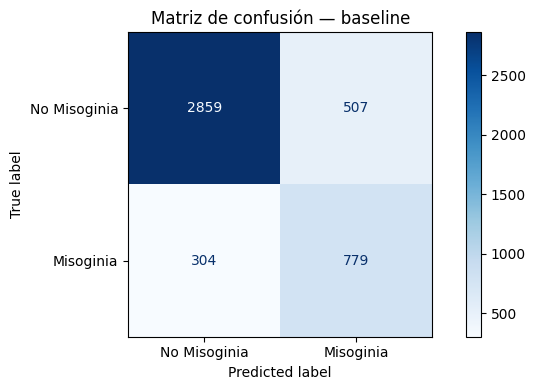


=== beto ===
              precision    recall  f1-score   support

No Misoginia       0.90      0.91      0.91      3366
   Misoginia       0.72      0.70      0.71      1083

    accuracy                           0.86      4449
   macro avg       0.81      0.81      0.81      4449
weighted avg       0.86      0.86      0.86      4449



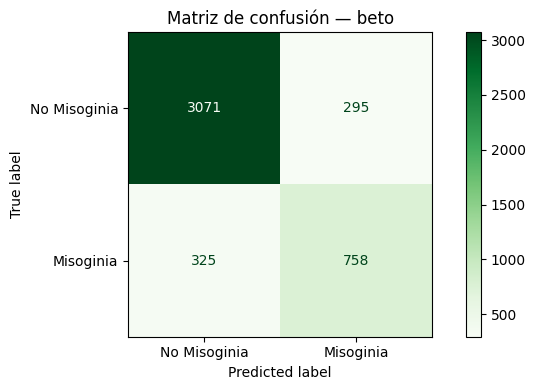


=== roberta ===
              precision    recall  f1-score   support

No Misoginia       0.90      0.90      0.90      3366
   Misoginia       0.69      0.69      0.69      1083

    accuracy                           0.85      4449
   macro avg       0.80      0.80      0.80      4449
weighted avg       0.85      0.85      0.85      4449



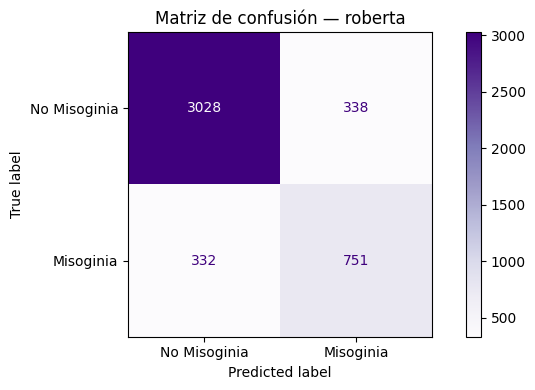

In [24]:
# =========================================================
# Evaluación: Baseline + BETO + RoBERTa
# (lee artefactos, evalúa y guarda métricas + matrices)
# =========================================================
from pathlib import Path
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ---------- 1) Rutas base ----------
ROOT       = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPO       = ROOT / "reports";        REPO.mkdir(parents=True, exist_ok=True)
ART_BASE   = ROOT / "artifacts" / "baseline_es"
ART_BERT   = ROOT / "artifacts" / "bert_es"
ART_ROBERTA= ROOT / "artifacts" / "roberta_es"

# ---------- 2) Cargar TEST ----------
def load_test_df():
    DATA = ROOT / "data"
    for p in [DATA/"test_clean.csv", DATA/"test.csv"]:
        if p.exists():
            df = pd.read_csv(p)
            if "text_clean" in df.columns and "text" not in df.columns:
                df = df.rename(columns={"text_clean":"text"})
            assert {"text","label"}.issubset(df.columns), f"Faltan columnas en {p.name}"
            return df[["text","label"]].dropna().reset_index(drop=True)

    final_csv = DATA / "final_labels.csv"
    if final_csv.exists():
        df = pd.read_csv(final_csv)
        if "text" not in df.columns:
            for c in ["body","content","tweet","sentence","message"]:
                if c in df.columns: df = df.rename(columns={c:"text"}); break
        if "label" not in df.columns:
            for c in ["level_1","target","labels","y","is_sexist","misogyny"]:
                if c in df.columns: df = df.rename(columns={c:"label"}); break
        assert {"text","label"}.issubset(df.columns), "No pude inferir columnas text/label"
        from sklearn.model_selection import train_test_split
        _, df_test = train_test_split(df[["text","label"]], test_size=0.2, random_state=42, stratify=df["label"])
        return df_test.reset_index(drop=True)

    raise FileNotFoundError("No encuentro data/test_clean.csv/test.csv/final_labels.csv")

df_test = load_test_df()
print(f"✅ Test cargado: {df_test.shape}")

# ---------- 3) Predicción con modelos HF ----------
def predict_dir_hf(model_dir: Path, texts, batch_size: int = 64, max_len_default: int = 256):
    model = AutoModelForSequenceClassification.from_pretrained(str(model_dir))
    tokenizer = AutoTokenizer.from_pretrained(str(model_dir))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    max_len_cfg = getattr(tokenizer, "model_max_length", max_len_default)
    max_len = max_len_default if max_len_cfg > 10000 else int(max_len_cfg)

    preds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(device)
            logits = model(**enc).logits
            preds.extend(logits.argmax(dim=-1).tolist())
    return np.array(preds, dtype=int)

# ---------- 4) Predicción baseline sklearn ----------
def predict_baseline_artifacts(texts):
    pipe_path = ART_BASE / "tfidf_lr.joblib"
    if pipe_path.exists():
        pipe = joblib.load(pipe_path)
        return pipe.predict(texts).astype(int)

    vec_path  = ART_BASE / "tfidf_vectorizer.pkl"
    clf_main  = ART_BASE / "logreg_guest_model.pkl"
    clf_alt   = ART_BASE / "clf.pkl"
    if vec_path.exists() and (clf_main.exists() or clf_alt.exists()):
        vec = joblib.load(vec_path); clf = joblib.load(clf_main if clf_main.exists() else clf_alt)
        return clf.predict(vec.transform(texts)).astype(int)

    raise FileNotFoundError("No encuentro artefactos del baseline en artifacts/baseline_es/")

# ---------- 5) Evaluación + guardado ----------
def eval_and_save(nombre: str, y_true: np.ndarray, y_pred: np.ndarray, cmap='Blues'):
    rep_dict = classification_report(y_true, y_pred,
                                     target_names=["No Misoginia","Misoginia"],
                                     output_dict=True, zero_division=0)
    rep_txt = classification_report(y_true, y_pred,
                                    target_names=["No Misoginia","Misoginia"],
                                    digits=2, zero_division=0)
    print(f"\n=== {nombre} ===\n{rep_txt}")

    (REPO/f"{nombre.lower()}_metrics.json").write_text(json.dumps(rep_dict, indent=2), encoding="utf-8")
    (REPO/f"{nombre.lower()}_metrics.txt").write_text(rep_txt, encoding="utf-8")

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            display_labels=["No Misoginia","Misoginia"], cmap=cmap)
    plt.title(f"Matriz de confusión — {nombre}")
    plt.tight_layout()
    plt.savefig(REPO / f"confusion_{nombre.lower()}.png", dpi=160)
    plt.show()
    return rep_dict

# ---------- 6) Ejecutar evaluaciones (SIN barplot aquí) ----------
# Baseline
try:
    y_pred_base = predict_baseline_artifacts(df_test["text"].tolist())
    rep_base = eval_and_save("baseline", df_test["label"].values, y_pred_base, cmap="Blues")
except Exception as e:
    print("ℹ️ Baseline no evaluado:", e)

# BETO
if ART_BERT.exists():
    try:
        y_pred_bert = predict_dir_hf(ART_BERT, df_test["text"].tolist())
        rep_bert = eval_and_save("beto", df_test["label"].values, y_pred_bert, cmap="Greens")
    except Exception as e:
        print("⚠️ Error evaluando BETO:", e)
else:
    print(f"⚠️ No se encontró {ART_BERT}")

# RoBERTa
if ART_ROBERTA.exists():
    try:
        y_pred_roberta = predict_dir_hf(ART_ROBERTA, df_test["text"].tolist())
        rep_roberta = eval_and_save("roberta", df_test["label"].values, y_pred_roberta, cmap="Purples")
    except Exception as e:
        print("⚠️ Error evaluando RoBERTa:", e)
else:
    print(f"⚠️ No se encontró {ART_ROBERTA}")


,Modelo,F1-macro,Accuracy
0,BETO,0.8090,0.8606
1,RoBERTa,0.7960,0.8494
2,Baseline (TF-IDF+LR),0.7667,0.8177


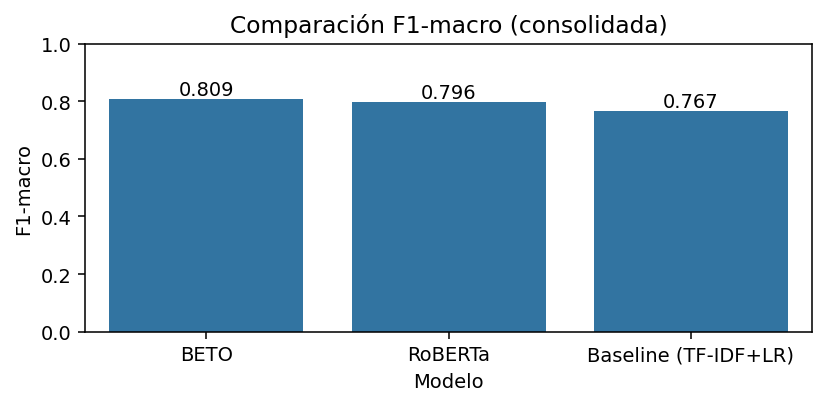

💾 Guardado: c:\Users\VICTUS\Downloads\TESIS codigo\reports\comparacion_metricas.csv
🖼️ Guardado: c:\Users\VICTUS\Downloads\TESIS codigo\reports\comparacion_f1_tesis.png


In [25]:
# === Comparación final (lee métricas ya guardadas en /reports) ===
import json
import pandas as pd
import matplotlib.pyplot as plt

# intenta usar seaborn; si no, cae a matplotlib
try:
    import seaborn as sns
    USE_SNS = True
except Exception:
    USE_SNS = False

rows = []

def add_row(name, path):
    if path.exists():
        rep = json.load(open(path, "r", encoding="utf-8"))
        rows.append({
            "Modelo": name,
            "F1-macro": float(rep["macro avg"]["f1-score"]),
            "Accuracy": float(rep["accuracy"])
        })

add_row("Baseline (TF-IDF+LR)", REPO / "baseline_metrics.json")
add_row("BETO",                 REPO / "beto_metrics.json")
add_row("RoBERTa",              REPO / "roberta_metrics.json")

df_comp = pd.DataFrame(rows)
if df_comp.empty:
    print("⚠️ No hay métricas para comparar. ¿Ya corriste baseline/BETO/RoBERTa?")
else:
    df_comp = df_comp.sort_values("F1-macro", ascending=False).reset_index(drop=True)
    display(df_comp.round(4))

    # guardar tabla
    out_csv = REPO / "comparacion_metricas.csv"
    df_comp.to_csv(out_csv, index=False, encoding="utf-8")

    # gráfico
    plt.figure(figsize=(6,3), dpi=140)
    if USE_SNS:
        ax = sns.barplot(data=df_comp, x="Modelo", y="F1-macro")
        ax.bar_label(ax.containers[0], fmt="%.3f")
    else:
        plt.bar(df_comp["Modelo"], df_comp["F1-macro"])
        for i, v in enumerate(df_comp["F1-macro"]):
            plt.text(i, v+0.01, f"{v:.3f}", ha="center", va="bottom")
    plt.ylim(0,1)
    plt.title("Comparación F1-macro (consolidada)")
    plt.tight_layout()
    out_png = REPO / "comparacion_f1_tesis.png"
    plt.savefig(out_png, dpi=160)
    plt.show()

    print("💾 Guardado:", out_csv)
    print("🖼️ Guardado:", out_png)


In [68]:
# === Checkpoint final: guardar artefactos y reportes ===
import shutil, datetime

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
zip_name = f"checkpoint_tesis_{ts}.zip"

bases = []
if (ROOT/"artifacts").exists(): bases.append(("artifacts","artifacts"))
if (ROOT/"reports").exists():   bases.append(("reports","reports"))

if not bases:
    print("⚠️ No encontré carpetas para comprimir.")
else:
    bundle = ROOT / "_bundle"
    if bundle.exists():
        shutil.rmtree(bundle)
    bundle.mkdir(parents=True)
    
    for src_name, dst_name in bases:
        shutil.copytree(ROOT/src_name, bundle/dst_name)

    shutil.make_archive(zip_name.replace(".zip",""), "zip", bundle)
    shutil.rmtree(bundle)
    print(f"✅ Checkpoint creado: {zip_name}")
    print("Incluye:", ", ".join(name for name,_ in bases))


KeyboardInterrupt: 